In [1]:
import silq
silq.initialize("EWJN", mode='analysis')
%matplotlib notebook

Initializing imports


<IPython.core.display.Javascript object>

Initializing functions
Initializing data
Initializing analysis
Initializing plotting
Initialization complete


In [2]:
import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
font = {'family' : 'monospace',
        'weight' : 'regular',
        'size'   : 16}

matplotlib.rc('font', **font) 
config['user'].get('matplot', {})['2D_settings']['cmap']='inferno'
#plt.style.use('classic')
#print(plt.style.available)

# charge stability diagram

<IPython.core.display.Javascript object>


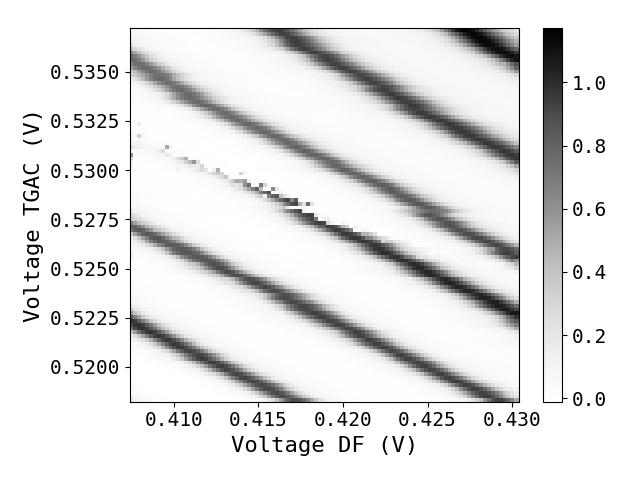

In [194]:
data = qc.load_data('2017-01-31/#003_DC_2D_arb_sweep_09-49-12')

tgac_sim = data.parameter_info('TGAC')['TGAC']
df_sim = data.parameter_info('DF_DS')['DF_DS']

df_arb_steps = data.amplitude_set[:]*1/20
tgac_sweep_points = data.amplitude_set[:]*1/24.2

df_vals = df_arb_steps+df_sim
tgac_vals = tgac_sweep_points+tgac_sim


plt.figure()

plt.pcolormesh(df_vals,tgac_vals,data.DC_voltage, cmap='Greys')

plunge_values = np.arange(0.04, 0.144, 0.01)
scale = [-1, 15/8]
#plt.plot(df_sim+plunge_values/scale[0], tgac_sim+plunge_values/scale[1], '.')
#plt.plot(df_sim, tgac_sim, 'or')
plt.xlabel('Voltage DF (V)')
plt.ylabel('Voltage TGAC (V)')
plt.colorbar()
plt.tight_layout()
plt.savefig('chargestability_diagram.png')

# Baysian filtered initialisation

# Magnetic field dependence 

In [125]:
class T1_Measurement_Set:
    def __init__(self, T1_msmts):
        self.T1_msmts = {T1_msmt.B0: T1_msmt for T1_msmt in T1_msmts}
        
    def calculate_values(self):
        self.B0_fields = np.array(list(self.T1_msmts.keys()))
        self.idx_sorted = np.argsort(self.B0_fields)
        self.B0_fields = self.B0_fields[self.idx_sorted]
        self.T1_values = np.array([self.T1_msmts[B0].T1 for B0 in self.B0_fields])
        self.T1_std = np.array([self.T1_msmts[B0].T1_std for B0 in self.B0_fields])
        self.T1_rates = 1/self.T1_values
        
        self.fit_curve()

    def fit_curve(self):
        def B_polynomial(x, exponent, amplitude, offset):
            return amplitude*x**exponent + offset
        def B5_polynomial(x, amplitude, offset):
            return amplitude*x**5 + offset

        fit_model = lmfit.Model(B_polynomial)
        parameters=lmfit.Parameters()
        parameters.add('exponent', 2)
        parameters.add('amplitude', 1e-7, vary=True)
        parameters.add('offset', 0*10**-4, vary=True)
        self.fit_result = fit_model.fit(self.T1_rates, x=self.B0_fields, params=parameters)
    
    def plot_T1_rates(self, ax=None, label=None, plot_fit=True, **kwargs):
        if ax is None:
            fig, ax = plt.subplots(1,1)
        else:
            fig = plt.gcf()
            
        if label is None:
            label = 'data'
        
        yerr = self.T1_std / self.T1_values * self.T1_rates
        ax.errorbar(self.B0_fields, self.T1_rates*1e3, yerr=yerr, marker='o', linestyle='', label=label, **kwargs)
        if plot_fit:
            ax.plot(self.B0_fields, self.fit_result.best_fit*1e3, '-', label="$\delta + A \cdot B^x$ fit")
#         ax.plot(self.B0_fields, B5_fit_result.best_fit, '-', label="$\delta + A \cdot B^5$ fit")

        ax.set_xscale('log')
        ax.set_yscale('log')
        # ax.set_xlim(.7, 5.5)
        # xticks = [.7,1,1.5,2,3,4,5,6]
        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticks)

        ax.set_xlabel('Magnetic field (T)')
        ax.set_ylabel(r'Relaxation rate $\,T_1^{-1}$ ($\mathrm{s}^{-1})$')

        ax.legend(loc='best', numpoints=1, fontsize=16)
        
        return fig, ax

In [126]:
T1_msmt_set_old = T1_Measurement_Set(
    [T1_Measurement(B0=4,   location='2016-09-11/#014_T1_data_01-49-04'),
     T1_Measurement(B0=4.5, location='2016-09-10/#004_T1_data_00-08-32'),
     T1_Measurement(B0=5,   location='2016-09-10/#017_T1_data_13-39-35'),
     T1_Measurement(B0=3.5, location='2016-09-08/#003_T1_data_09-57-29'),
     T1_Measurement(B0=3,   location='2016-09-06/#013_T1_data_20-53-43'),
     T1_Measurement(B0=2.5,   location='2016-09-12/#012_T1_data_18-05-27', skip=-1),
     T1_Measurement(B0=2,   location='2016-09-13/#010_T1_data_13-46-56', skip=-1),
     T1_Measurement(B0=1.5,   location='2016-09-14/#034_T1_data_17-13-07'),
     T1_Measurement(B0=1.4,   location='2016-09-15/#012_T1_data_14-52-32'),
     T1_Measurement(B0=1.2,   location='2016-09-16/#011_T1_data_13-04-18'),
     T1_Measurement(B0=1,   location='2016-09-17/#012_T1_data_12-42-07'),
     T1_Measurement(B0=0.8,   location='2016-09-18/#010_T1_data_13-54-44'),
     T1_Measurement(B0=0.6,   location='2016-09-19/#022_T1_data_15-52-22'),
     T1_Measurement(B0=0.4, location='2016-09-20/#040_T1_data_16-47-57')])

# Add tau=25s measurements for B0=0.4T
T1_msmt_set_old.T1_msmts[0.4].add_data("2016-09-21\#008_T1_data_high_12-08-03", T1_wait_time=25000)
T1_msmt_set_old.calculate_values()

NameError: name 'T1_Measurement' is not defined

In [ ]:
T1_msmt_set_new = T1_Measurement_Set(
    [T1_Measurement(B0=1.2, location='2016-10-13/#040_T1_data_19-17-49'),
     T1_Measurement(B0=1.1, location='2016-10-14/#005_T1_data_22-53-15'),
     T1_Measurement(B0=1.0, location='2016-10-16/#004_T1_data_11-46-07'),
     T1_Measurement(B0=0.9, location='2016-10-17/#003_T1_data_13-12-20'),
     T1_Measurement(B0=0.8, location='2016-10-18/#003_T1_data_14-22-14'),
     T1_Measurement(B0=0.7, location='2016-10-21/#009_T1_data_17-09-21')])
T1_msmt_set_new.calculate_values()

In [ ]:
T1_msmt_set_new2 = T1_Measurement_Set(
    [T1_Measurement(B0=1.2, location='2016-11-21/#016_T1_data_18-02-24'),
     T1_Measurement(B0=0.9, location='2016-11-23/#006_T1_data_14-50-59'),
     T1_Measurement(B0=0.9, location='2016-12-01/#002_T1_data_16-24-56'),
     T1_Measurement(B0=0.85, location='2016-12-02/#036_T1_data_21-57-51')])
T1_msmt_set_new2.calculate_values()

In [ ]:
# 1T set at plunge of 1.8V
'2016-12-15/#021_T1_data_12-30-35' C1
'2016-12-18/#001_T1_data_11-46-20' 2V
'2016-12-17/#004_T1_data_15-52-24' C2
'2016-12-17/#005_T1_data_20-59-42'

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [ ]:
fig, ax = T1_msmt_set_old.plot_T1_rates(label='Old measurements')
T1_msmt_set_new.plot_T1_rates(ax=ax, label='New measurements', plot_fit=False)
xticks = [0.1,0.2,0.4,0.6,1,2,3,4,5,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
fig.tight_layout()

# SET electron number dependence

In [65]:
for k, msmt_nums, (x, y) in enumerate(msmts):
    print(k)

ValueError: not enough values to unpack (expected 3, got 2)

<IPython.core.display.Javascript object>


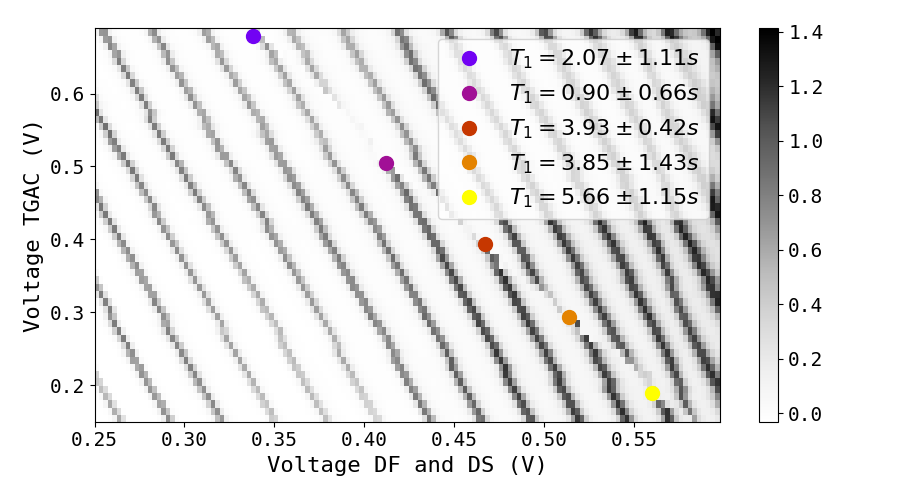

In [69]:
data = qc.load_data('2016-12-30/#011_DC_TGAC_vs_DF_DS_scan_14-12-34')
plt.figure(figsize=(9,5))
plt.pcolormesh(data.DF_DS_set[1],data.TGAC_set[0:],  data.DC_voltage, cmap='Greys')
msmts = [('2.07 \pm 1.11', (0.338, 0.679)),# Measurement 11
         ('0.90 \pm 0.66', (0.412, 0.505)), # Measurements 4, 10
         ('3.93 \pm 0.42', (0.467, 0.393)), # Measurement 5
         ('3.85 \pm 1.43', (0.514, 0.293)), # Measurement 8
         ('5.66 \pm 1.15', (0.56, 0.19))]  # Measurements 6, 7, 9 
k=1
for msmt_nums, (x, y) in msmts:
    plt.plot(x, y, 'o', label=r'$T_1={}s$'.format(msmt_nums), markersize=10, color=plt.cm.gnuplot(k/5))
    k=k+1
plt.legend(loc='upper right')
plt.xlabel('Voltage DF and DS (V)')
plt.ylabel('Voltage TGAC (V)')
plt.colorbar()
plt.tight_layout()
plt.savefig('electronnumber_dependence.png')

In [ ]:
msmts = [('0.90 \pm 0.66', (0.415, 0.488)), # Measurements 4, 10
         ('3.93 \pm 0.42', (0.467, 0.393)), # Measurement 5
         ('5.66 \pm 1.15', (0.548, 0.21)),  # Measurements 6, 7, 9
         ('3.85 \pm 1.43', (0.505, 0.293)), # Measurement 8
         ('2.07 \pm 1.11', (0.338, 0.679))] # Measurement 11

In [7]:
plt.cm.

(0.0078431372549019607, 0.99215686274509807, 1.0, 1.0)

Number of successful sweeps: 21
Number of successful sweeps: 49
Number of successful sweeps: 38
Number of successful sweeps: 10
Number of successful sweeps: 19


<IPython.core.display.Javascript object>


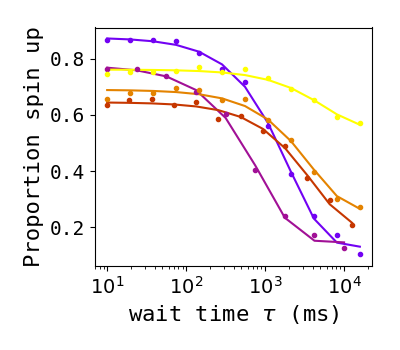

0
1
2
3
4


In [71]:
T1_msmt5 = T1_Analysis(location='2016-12-25/#009_T1_data_22-51-12')
T1_msmt4 = T1_Analysis(location='2016-12-24/#044_T1_data_20-52-14')
T1_msmt3 = T1_Analysis(location='2016-12-18/#001_T1_data_11-46-20' ,T1_label='up_proportion_5_0_0')
T1_msmt2 = T1_Analysis('2016-12-15/#021_T1_data_12-30-35', T1_label='up_proportion_7_0_0')
T1_msmt1 = T1_Analysis('2016-12-30/#053_T1_data_23-04-20')

dataset = [T1_msmt1,T1_msmt2,T1_msmt3,T1_msmt4,T1_msmt5]
ne =['N-1', 'N-2', 'N-3', 'N-4', 'N-5']
plt.figure(figsize=(4,3.5))

for k,data in enumerate(dataset):
    print(k)
    up_proportion =  data.dataset.arrays[data.T1_label]
    up_proportions = np.nanmean(up_proportion, 0)
    num_not_nan = np.sum(~np.isnan(up_proportion), 0)
    std = np.nanstd(up_proportion, 0) / num_not_nan
    #plt.plot(data.T1_wait_times ,data.T1_data_mean, '.')
    l,=plt.plot(data.T1_wait_times, data.fit_result.best_fit, color=plt.cm.gnuplot((k+1)/len(dataset)))
    plt.errorbar(data.T1_wait_times, data.T1_data_mean, std, fmt='o', ms=3, color=l._color,
                     label=r'${:3.2}$s - {}'.format(data.T1/1e3,
                                                      ne[k]))

plt.xscale('log')
plt.xlabel('wait time $\\tau$ (ms)')
plt.ylabel('Proportion spin up')
#plt.legend(handlelength=1, title=r'$T_1 - n_e$', fontsize=9)
plt.tight_layout()
plt.savefig('electronnumber_dependence2.png')

# plunge voltage dependence

<IPython.core.display.Javascript object>


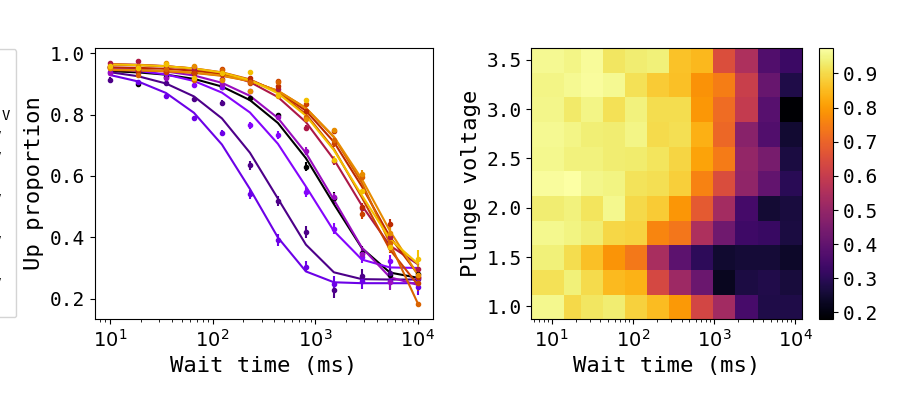

Number of successful sweeps: 10
Number of successful sweeps: 10
Number of successful sweeps: 10
Number of successful sweeps: 10
Number of successful sweeps: 10
Number of successful sweeps: 10
Number of successful sweeps: 10
Number of successful sweeps: 10
Number of successful sweeps: 9
Number of successful sweeps: 9
Number of successful sweeps: 9


In [76]:
#purple point T1 plunge depenedence
T1_analysis = T1_Analysis('2017-01-04/#010_T1_plunge_voltage_10-06-38', T1_label='up_proportion_2_0_0', analyse=False)
data = T1_analysis.dataset

plot = qc.MatPlot(subplots=2)

T1_wait_times = data.T1_wait_time_ESR_set[0][0]
plunge_amplitudes = data.plunge_amplitude_set[0]
up_proportions = np.nanmean(data.up_proportion_2_0_0, 0)
num_not_nan = np.sum(~np.isnan(data.up_proportion_2_0_0), 0)
std = np.nanstd(data.up_proportion_2_0_0, 0) / num_not_nan
purple_T1 = []
purple_T1_std = []
for k, up_proportion in enumerate(up_proportions):
    T1_analysis.analyse_data(T1_data=T1_analysis.dataset.up_proportion_2_0_0[:,k],
                             T1_wait_times=T1_wait_times)
    line, = plot[0].plot(T1_analysis.T1_wait_times, T1_analysis.fit_result.best_fit, color=plt.cm.gnuplot(k/len(up_proportions)))
    plot[0].errorbar(T1_wait_times, up_proportion, yerr=std[k], fmt='o', ms=3, color=line._color,
                     label=r'${:3.2}$s - {} V'.format(T1_analysis.T1/1e3,
                                                      plunge_amplitudes[k]))
    purple_T1.append(T1_analysis.T1)
    purple_T1_std.append(T1_analysis.T1_std)
    
plot[0].set_xscale('log')
legend=plot[0].legend(handlelength=1, title=r'$T_1 - V_{plunge}$', fontsize=10, bbox_to_anchor=(-0.21, 1.02))
plot[0].set_xlabel('Wait time (ms)')
plot[0].set_ylabel('Up proportion')

plot[1].add(np.nanmean(data.up_proportion_2_0_0, 0),
            x=data.T1_wait_time_ESR_set[0],
            y=data.plunge_amplitude_set[0])
plot[1].set_xlabel('Wait time (ms)')
plot[1].set_ylabel('Plunge voltage')
plot[1].set_xscale('log')

plot.tight_layout()
art = []
art.append(legend)
plt.savefig(
    "plungedepexample1.png", additional_artists=art,
    bbox_inches="tight")

<IPython.core.display.Javascript object>


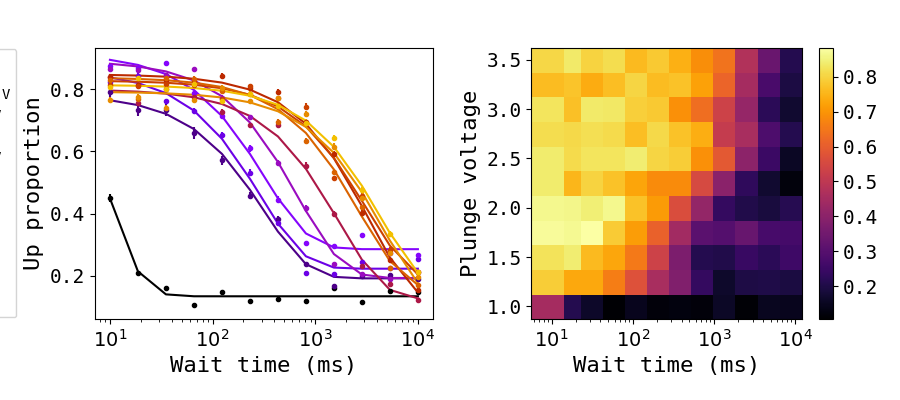

Number of successful sweeps: 11
Number of successful sweeps: 11
Number of successful sweeps: 11
Number of successful sweeps: 11
Number of successful sweeps: 11
Number of successful sweeps: 11
Number of successful sweeps: 11
Number of successful sweeps: 11
Number of successful sweeps: 10
Number of successful sweeps: 10
Number of successful sweeps: 10


In [77]:
#blue peak
T1_analysis = T1_Analysis('2017-01-06/#005_T1_plunge_voltage_13-33-22', T1_label='up_proportion_2_0_0', analyse=False)
data = T1_analysis.dataset

plot = qc.MatPlot(subplots=2)

T1_wait_times = data.T1_wait_time_ESR_set[0][0]
plunge_amplitudes = data.plunge_amplitude_set[0]
up_proportions = np.nanmean(data.up_proportion_2_0_0, 0)
num_not_nan = np.sum(~np.isnan(data.up_proportion_2_0_0), 0)
std = np.nanstd(data.up_proportion_2_0_0, 0) / num_not_nan
blue_T1 = []
blue_T1_std = []
for k, up_proportion in enumerate(up_proportions):
    T1_analysis.analyse_data(T1_data=T1_analysis.dataset.up_proportion_2_0_0[:,k],
                             T1_wait_times=T1_wait_times)
    l, = plot[0].plot(T1_analysis.T1_wait_times, T1_analysis.fit_result.best_fit, color=plt.cm.gnuplot(k/len(up_proportions)))
    plot[0].errorbar(T1_wait_times, up_proportion, yerr=std[k], fmt='o', ms=3, color=l._color,
                     label=r'${:3.2}$s - {} V'.format(T1_analysis.T1/1e3,
                                                      plunge_amplitudes[k]))
    blue_T1.append(T1_analysis.T1)
    blue_T1_std.append(T1_analysis.T1_std)
    
plot[0].set_xscale('log')
legend=plot[0].legend(handlelength=1, title=r'$T_1 - V_{plunge}$', fontsize=10, bbox_to_anchor=(-0.21, 1.02))
plot[0].set_xlabel('Wait time (ms)')
plot[0].set_ylabel('Up proportion')

plot[1].add(np.nanmean(data.up_proportion_2_0_0, 0),
            x=data.T1_wait_time_ESR_set[0],
            y=data.plunge_amplitude_set[0])
plot[1].set_xlabel('Wait time (ms)')
plot[1].set_ylabel('Plunge voltage')
plot[1].set_xscale('log')

plot.tight_layout()
art = []
art.append(legend)
plt.savefig(
    "plungedepexample2.png", additional_artists=art,
    bbox_inches="tight")


<IPython.core.display.Javascript object>


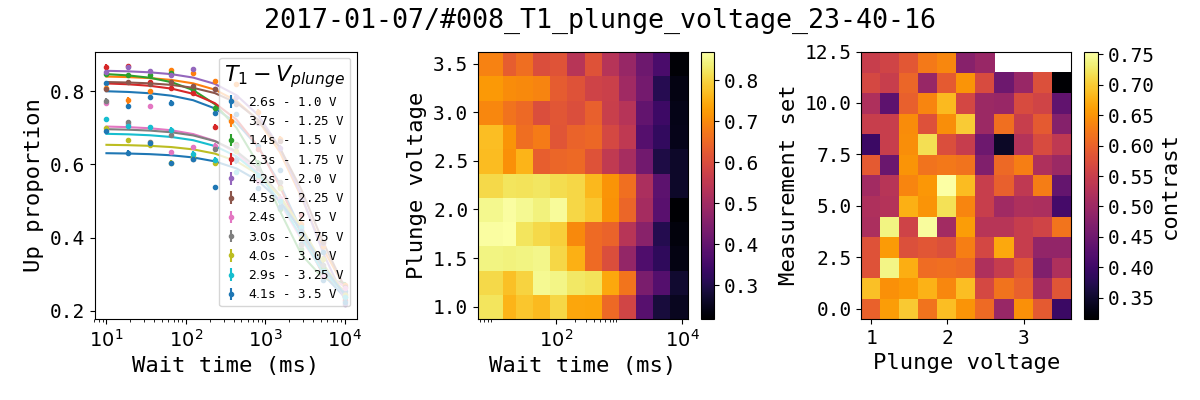

Number of successful sweeps: 13
Number of successful sweeps: 13
Number of successful sweeps: 13
Number of successful sweeps: 13
Number of successful sweeps: 13
Number of successful sweeps: 13
Number of successful sweeps: 12
Number of successful sweeps: 12
Number of successful sweeps: 12
Number of successful sweeps: 12
Number of successful sweeps: 12


In [40]:
#orange peak
T1_analysis = T1_Analysis('2017-01-07/#008_T1_plunge_voltage_23-40-16', T1_label='up_proportion_2_0_0', analyse=False)
data = T1_analysis.dataset

plot = qc.MatPlot(subplots=3)

T1_wait_times = data.T1_wait_time_ESR_set[0][0]
plunge_amplitudes = data.plunge_amplitude_set[0]
up_proportions = np.nanmean(data.up_proportion_2_0_0, 0)
num_not_nan = np.sum(~np.isnan(data.up_proportion_2_0_0), 0)
std = np.nanstd(data.up_proportion_2_0_0, 0) / num_not_nan
orange_T1 = []
orange_T1_std = []
for k, up_proportion in enumerate(up_proportions):
    T1_analysis.analyse_data(T1_data=T1_analysis.dataset.up_proportion_2_0_0[:,k],
                             T1_wait_times=T1_wait_times)
    l, = plot[0].plot(T1_analysis.T1_wait_times, T1_analysis.fit_result.best_fit)
    plot[0].errorbar(T1_wait_times, up_proportion, yerr=std[k], fmt='o', ms=3, color=l._color,
                     label=r'${:3.2}$s - {} V'.format(T1_analysis.T1/1e3,
                                                      plunge_amplitudes[k]))
    orange_T1.append(T1_analysis.T1)
    orange_T1_std.append(T1_analysis.T1_std)
    
plot[0].set_xscale('log')
plot[0].legend(handlelength=1, title=r'$T_1 - V_{plunge}$', fontsize=9)
plot[0].set_xlabel('Wait time (ms)')
plot[0].set_ylabel('Up proportion')

plot[1].add(np.nanmean(data.up_proportion_2_0_0, 0),
            x=data.T1_wait_time_ESR_set[0],
            y=data.plunge_amplitude_set[0])
plot[1].set_xlabel('Wait time (ms)')
plot[1].set_ylabel('Plunge voltage')
plot[1].set_xscale('log')

plot.tight_layout()
plot[2].add(data.contrast)
plot[2].set_xlabel('Plunge voltage')
plot[2].set_ylabel('Measurement set')


<IPython.core.display.Javascript object>


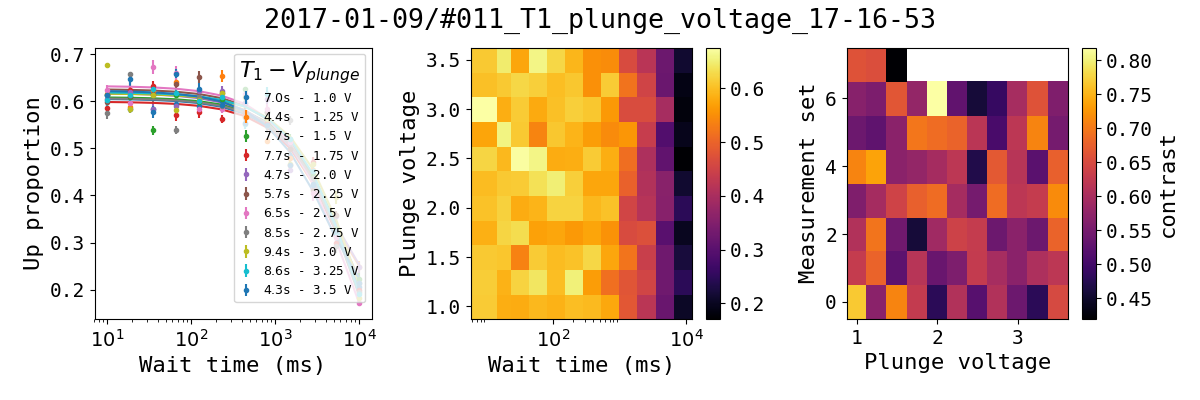

Number of successful sweeps: 8
Number of successful sweeps: 8
Number of successful sweeps: 7
Number of successful sweeps: 7
Number of successful sweeps: 7
Number of successful sweeps: 7
Number of successful sweeps: 7
Number of successful sweeps: 7
Number of successful sweeps: 7
Number of successful sweeps: 7
Number of successful sweeps: 7


In [41]:
# red peak 
T1_analysis = T1_Analysis('2017-01-09/#011_T1_plunge_voltage_17-16-53', T1_label='up_proportion_2_0_0', analyse=False)
data = T1_analysis.dataset

plot = qc.MatPlot(subplots=3)

T1_wait_times = data.T1_wait_time_ESR_set[0][0]
plunge_amplitudes = data.plunge_amplitude_set[0]
up_proportions = np.nanmean(data.up_proportion_2_0_0, 0)
num_not_nan = np.sum(~np.isnan(data.up_proportion_2_0_0), 0)
std = np.nanstd(data.up_proportion_2_0_0, 0) / num_not_nan
red_T1 = []
red_T1_std = []
for k, up_proportion in enumerate(up_proportions):
    T1_analysis.analyse_data(T1_data=T1_analysis.dataset.up_proportion_2_0_0[:,k],
                             T1_wait_times=T1_wait_times)
    l, = plot[0].plot(T1_analysis.T1_wait_times, T1_analysis.fit_result.best_fit)
    plot[0].errorbar(T1_wait_times, up_proportion, yerr=std[k], fmt='o', ms=3, color=l._color,
                     label=r'${:3.2}$s - {} V'.format(T1_analysis.T1/1e3,
                                                      plunge_amplitudes[k]))
    red_T1.append(T1_analysis.T1)
    red_T1_std.append(T1_analysis.T1_std)
    
plot[0].set_xscale('log')
plot[0].legend(handlelength=1, title=r'$T_1 - V_{plunge}$', fontsize=9)
plot[0].set_xlabel('Wait time (ms)')
plot[0].set_ylabel('Up proportion')

plot[1].add(np.nanmean(data.up_proportion_2_0_0, 0),
            x=data.T1_wait_time_ESR_set[0],
            y=data.plunge_amplitude_set[0])
plot[1].set_xlabel('Wait time (ms)')
plot[1].set_ylabel('Plunge voltage')
plot[1].set_xscale('log')

plot.tight_layout()
plot[2].add(data.contrast)
plot[2].set_xlabel('Plunge voltage')
plot[2].set_ylabel('Measurement set')

In [50]:
volts=[volt*1e3 for volt in plunge_voltages]

<IPython.core.display.Javascript object>


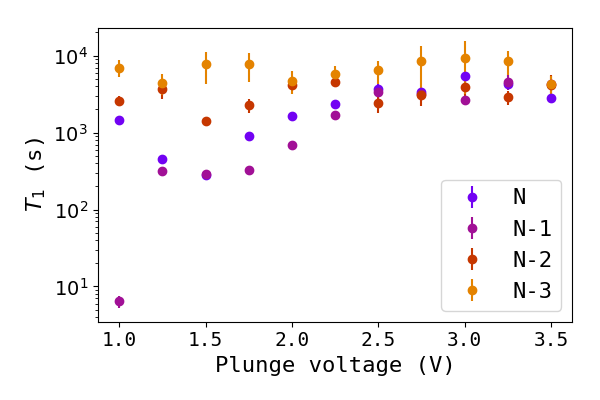

In [72]:
#Summary plunge T1 times
plunge_voltages = list(np.arange(1,3.75, 0.25))
plot = qc.MatPlot()
#plot.add(plunge_voltages, purple_T1)|
#plot.add(plunge_voltages, blue_T1)
#plot.add(plunge_voltages, orange_T1)
plot[0].errorbar(plunge_voltages, purple_T1, yerr=purple_T1_std, marker='o', linestyle='', label='N', color=plt.cm.gnuplot(1/5))
plot[0].errorbar(plunge_voltages, blue_T1, yerr=blue_T1_std, marker='o', linestyle='', label='N-1', color=plt.cm.gnuplot(2/5))
plot[0].errorbar(plunge_voltages, orange_T1, yerr=orange_T1_std, marker='o', linestyle='', label='N-2', color=plt.cm.gnuplot(3/5))
plot[0].errorbar(plunge_voltages, red_T1, yerr=red_T1_std, marker='o', linestyle='', label='N-3', color=plt.cm.gnuplot(4/5))

plot[0].set_xlabel('Plunge voltage (V)')
plot[0].set_ylabel('$T_1$ (s)')
plot[0].legend()
plot[0].set_yscale('log')
plt.tight_layout()
plt.savefig('plungevoltageElectronumber.png')

# plunge direction dependence

<IPython.core.display.Javascript object>


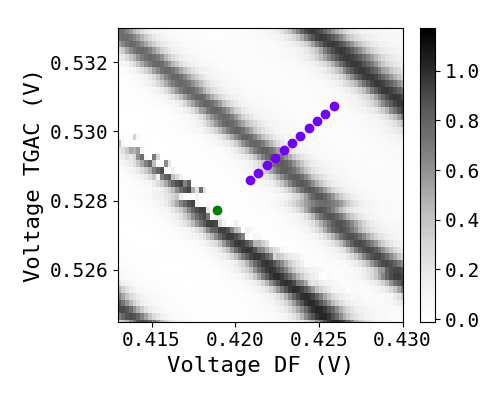

In [122]:
#data = qc.load_data('2017-01-27/#001_DC_2D_arb_sweep_10-32-01')
data = qc.load_data('2017-01-31/#003_DC_2D_arb_sweep_09-49-12')
#data = qc.load_data('2017-01-23/#020_DC_2D_arb_sweep_14-40-03')
tgac_sim = data.parameter_info('TGAC')['TGAC']
df_sim = data.parameter_info('DF_DS')['DF_DS']

df_arb_steps = data.amplitude_set[:]*1/20
tgac_sweep_points = data.amplitude_set[:]*1/24.2

df_vals = df_arb_steps+df_sim
tgac_vals = tgac_sweep_points+tgac_sim


plt.figure(figsize=(5,4))

plt.pcolormesh(df_vals,tgac_vals,data.DC_voltage, cmap='Greys')

plunge_values = np.arange(0.04, 0.144, 0.01)
scale = [1*20, 15/8*25]
plt.plot(df_sim+plunge_values/scale[0], tgac_sim+plunge_values/scale[1], 'o', color=plt.cm.gnuplot(1/5))
plt.plot(df_sim, tgac_sim, 'og')
plt.xlabel('Voltage DF (V)')
plt.ylabel('Voltage TGAC (V)')
plt.xlim((0.413, 0.43))
plt.ylim((0.5245,0.533))
plt.colorbar()
plt.tight_layout()
plt.savefig('chargestability_diagram_uncomp.png')



<IPython.core.display.Javascript object>


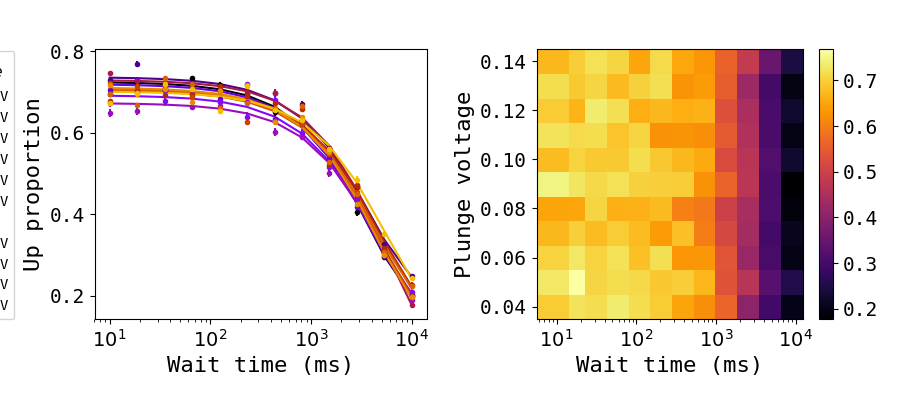

Number of successful sweeps: 16
Number of successful sweeps: 16
Number of successful sweeps: 16
Number of successful sweeps: 16
Number of successful sweeps: 16
Number of successful sweeps: 16
Number of successful sweeps: 16
Number of successful sweeps: 16
Number of successful sweeps: 16
Number of successful sweeps: 16
Number of successful sweeps: 16


In [114]:
T1_analysis = T1_Analysis('2017-01-25/#003_T1_free_plunge_voltage_16-11-13', T1_label='up_proportion_2_0_0', analyse=False)
data = T1_analysis.dataset

plot = qc.MatPlot(subplots=2)

T1_wait_times = data.T1_wait_time_ESR_set[0][0]
plunge_amplitudes = data.amplitude_set[0]
up_proportions = np.nanmean(data.up_proportion_2_0_0, 0)
num_not_nan = np.sum(~np.isnan(data.up_proportion_2_0_0), 0)
std = np.nanstd(data.up_proportion_2_0_0, 0) / num_not_nan
blue_T1 = []
blue_T1_std = []
for k, up_proportion in enumerate(up_proportions):
    T1_analysis.analyse_data(T1_data=T1_analysis.dataset.up_proportion_2_0_0[:,k],
                             T1_wait_times=T1_wait_times)
    l, = plot[0].plot(T1_analysis.T1_wait_times, T1_analysis.fit_result.best_fit, color=plt.cm.gnuplot(k/len(up_proportions)))
    plot[0].errorbar(T1_wait_times, up_proportion, yerr=std[k], fmt='o', ms=3, color=l._color,
                     label=r'${:3.2}$s - {} V'.format(T1_analysis.T1/1e3,
                                                      plunge_amplitudes[k]))
    blue_T1.append(T1_analysis.T1)
    blue_T1_std.append(T1_analysis.T1_std)
    
plot[0].set_xscale('log')
legend=plot[0].legend(handlelength=1, title=r'$T_1 - V_{plunge}$', fontsize=10, bbox_to_anchor=(-0.22, 1.02))
plot[0].set_xlabel('Wait time (ms)')
plot[0].set_ylabel('Up proportion')

plot[1].add(np.nanmean(data.up_proportion_2_0_0, 0),
            x=data.T1_wait_time_ESR_set[0],
            y=data.amplitude_set[0])
plot[1].set_xlabel('Wait time (ms)')
plot[1].set_ylabel('Plunge voltage')
plot[1].set_xscale('log')

plot.tight_layout()
art = []
art.append(legend)
plt.savefig(
    "plunge_uncomp1.png", additional_artists=art,
    bbox_inches="tight")


<IPython.core.display.Javascript object>


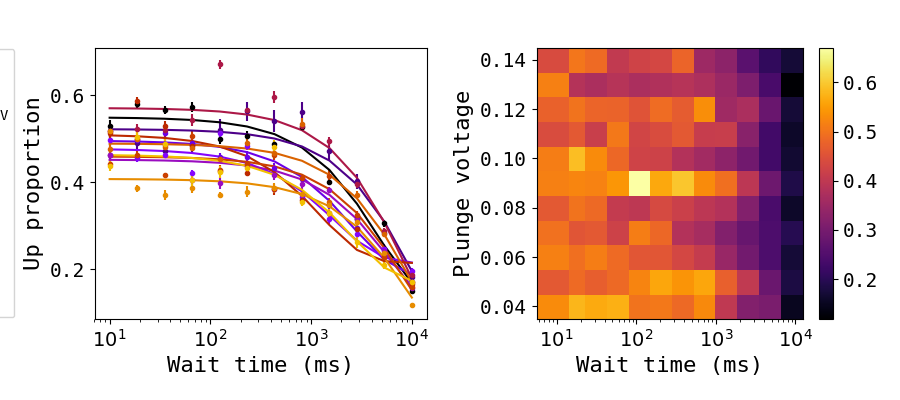

Number of successful sweeps: 8
Number of successful sweeps: 8
Number of successful sweeps: 8
Number of successful sweeps: 8
Number of successful sweeps: 8
Number of successful sweeps: 8
Number of successful sweeps: 8
Number of successful sweeps: 8
Number of successful sweeps: 7
Number of successful sweeps: 7
Number of successful sweeps: 7


In [124]:
T1_analysis = T1_Analysis('2017-01-23/#023_T1_free_plunge_voltage_16-45-22', T1_label='up_proportion_2_0_0', analyse=False)
data = T1_analysis.dataset

plot = qc.MatPlot(subplots=2)

T1_wait_times = data.T1_wait_time_ESR_set[0][0]
plunge_amplitudes = data.amplitude_set[0]
up_proportions = np.nanmean(data.up_proportion_2_0_0, 0)
num_not_nan = np.sum(~np.isnan(data.up_proportion_2_0_0), 0)
std = np.nanstd(data.up_proportion_2_0_0, 0) / num_not_nan
blue_T1 = []
blue_T1_std = []
for k, up_proportion in enumerate(up_proportions):
    T1_analysis.analyse_data(T1_data=T1_analysis.dataset.up_proportion_2_0_0[:,k],
                             T1_wait_times=T1_wait_times)
    l, = plot[0].plot(T1_analysis.T1_wait_times, T1_analysis.fit_result.best_fit, color=plt.cm.gnuplot(k/len(up_proportions)))
    plot[0].errorbar(T1_wait_times, up_proportion, yerr=std[k], fmt='o', ms=3, color=l._color,
                     label=r'${:3.2}$s - {} V'.format(T1_analysis.T1/1e3,
                                                      plunge_amplitudes[k]))
    blue_T1.append(T1_analysis.T1)
    blue_T1_std.append(T1_analysis.T1_std)
    
plot[0].set_xscale('log')
legend=plot[0].legend(handlelength=1, title=r'$T_1 - V_{plunge}$', fontsize=10, bbox_to_anchor=(-0.22, 1.02))
plot[0].set_xlabel('Wait time (ms)')
plot[0].set_ylabel('Up proportion')

plot[1].add(np.nanmean(data.up_proportion_2_0_0, 0),
            x=data.T1_wait_time_ESR_set[0],
            y=data.amplitude_set[0])
plot[1].set_xlabel('Wait time (ms)')
plot[1].set_ylabel('Plunge voltage')
plot[1].set_xscale('log')

plot.tight_layout()
art = []
art.append(legend)
plt.savefig(
    "plunge_uncomp2.png", additional_artists=art,
    bbox_inches="tight")